<a href="https://colab.research.google.com/github/abstractguy/lstm_autoencoder_classifier/blob/master/lstm_autoencoder_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LSTM Autoencoder for Rare Event Binary Classification

This is a continuation of the regular autoencoder for rare event classification presented in
https://towardsdatascience.com/extreme-rare-event-classification-using-autoencoders-in-keras-a565b386f098
and code present in
https://github.com/cran2367/autoencoder_classifier/blob/master/autoencoder_classifier.ipynb
Here we will show an implementation of building a binary classifier using LSTM Autoencoders. 
Similar to the previous post, the purpose is to show the implementation steps. The Autoencoder tuning for performance improvement can be done.

LSTM requires closer attention to preparing the data. Here we have all the steps, and few tests to validate the data preparation.

The dataset used here is taken from here,

**Dataset: Rare Event Classification in Multivariate Time Series** https://arxiv.org/abs/1809.10717 (please cite this article, if using the dataset).

In [0]:
# Hardcode sizes parameters.
main_ticker = 'FB'
tickers_list = ['INTC', 'AAPL', 'NVDA', 'CSCO', 'AMD', 'AMZN', 'GOOG', 'MSFT', 'S', 'BAC', 'XLNX', 'WFC', '^DJI', '^GSPC', '^NYA', '^IXIC']
#tickers_list = []
trends = False
unit_scaler = 7
epochs = 200
batch = 64
lr = 0.0001

SEED = 123 # Used to help randomly select the data points.
DATA_SPLIT_PCT = 0.2

In [2]:
!pip install pytrends

In [3]:
%matplotlib inline

from collections import OrderedDict
from math import sqrt
from os import chdir
from os.path import exists
from datetime import datetime
from tqdm import tqdm
from numpy.random import seed
from numpy import append, array, concatenate, count_nonzero, empty, empty_like, expand_dims, mean, nan, power, var, where, zeros
from pandas import concat, DataFrame, date_range, read_csv, Series
from pandas_datareader.data import DataReader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import auc, classification_report, confusion_matrix, f1_score, mean_squared_error, precision_recall_curve, precision_recall_fscore_support, recall_score, roc_curve
from tensorflow import set_random_seed
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import load_model, Model, Sequential
from keras.layers import Dense, Dropout, LSTM, RepeatVector, TimeDistributed
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, TerminateOnNaN
from keras.optimizers import Adam
from keras.utils import plot_model
from keras import optimizers, Sequential
from google.colab.drive import mount
from tensorboardcolab import TensorBoardColab, TensorBoardColabCallback
from pytrends.request import TrendReq
from pylab import rcParams

import matplotlib.pyplot as plt
import seaborn as sns

Using TensorFlow backend.


In [0]:
path = '/content/gdrive/'
mount(path)
path = path + 'My Drive/LSTM_autoencoder/'
chdir(path)

In [0]:
def add_ticker_to_tickers(symbol, ticker, tickers):
    minimum_date = ticker.index.min()
    overall_minimum_date = tickers.index.min()
    if minimum_date > overall_minimum_date:
        start = overall_minimum_date
        tickers = tickers[tickers.index >= minimum_date]

    tickers[symbol][tickers.index.isin(ticker.index)] = ticker

    return tickers

def get_stock(symbols, path=path, trends=True):
    csv_path = path + 'dataset.csv'

    if exists(csv_path):
        tickers = read_csv(csv_path)
    else:
        start = datetime(1970, 1, 1)
        end = datetime.now()
        dates = date_range(start=start, end=end)
        columns = concatenate([symbols, [(symbol + '_trend') for symbol in symbols[:-1]]]) if trends else symbols
        tickers = DataFrame(nan, index=dates, columns=columns)
        tickers.index.name = 'Date'
        if trends:
            pytrends = TrendReq(hl='en-US', tz=360)

        for symbol in tqdm(symbols, unit='symbol'):
            try:
                ticker = DataReader(symbol, 'yahoo', start=start, end=end).High.dropna()
                tickers = add_ticker_to_tickers(symbol, ticker, tickers)
                if trends:
                    pytrends.build_payload([symbol], timeframe='today 5-y')
                    ticker = pytrends.interest_over_time()[symbol]
                    tickers = add_ticker_to_tickers(symbol + '_trend', ticker, tickers)
            except:
                pass

        tickers = tickers.fillna(method='backfill')

        tickers.to_csv(csv_path)

    return tickers

def delta_time_series(data):
    return data[1:] - data[:-1]

def plot_dataset(dataset):
    plt.plot(dataset)
    plt.xlabel('Days')
    plt.ylabel('Derivatives')
    plt.show()

def get_y_from_generator(generator):
    """Get all targets y from a TimeseriesGenerator instance."""
    y = None

    for i in range(len(generator)):
        batch_y = generator[i][1]

        if y is None:
            y = batch_y
        else:
            y = append(y, batch_y)

    y = y.reshape((-1, 1))
    print(y.shape)
    return y

def binary_accuracy(a, b, name='training'):
    """Helper function to compute the match score of two binary numpy arrays."""
    a = a[:,0] > 0
    b = b[:,0] > 0
    assert len(a) == len(b)
    print('Binary accuracy (' + name + ' data):', (a == b).sum() / len(a))

def compute_units(X_train):
    sample_size, feature_size = X_train.shape
    units = int(((sample_size / unit_scaler) / length) - feature_size)
    print('Units:', units)
    return units

In [6]:
tickers_list = [main_ticker] + tickers_list
tickers_list = list(OrderedDict((ticker, True) for ticker in tickers_list).keys())
dataset = get_stock(tickers_list, trends=trends).dropna()

  0%|          | 0/17 [00:00<?, ?symbol/s]/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:8682: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
100%|██████████| 17/17 [00:24<00:00,  1.62s/symbol]


In [7]:
# THIS IS WHERE YOU HAVE TO DEFINE YOUR GROUND TRUTH!!
# THIS IS A DUMMY VALUE!!
dataset['y'] = (dataset[main_ticker] > 190).astype(int)
print('Percentage of ones (keep around 5%):', count_nonzero(dataset.y) / dataset.y.size)

Percentage of ones (keep around 5%): 0.045850701023114816


In [8]:
df = dataset.copy()
df.reset_index()

,Date,FB,INTC,AAPL,NVDA,CSCO,AMD,AMZN,GOOG,MSFT,S,BAC,XLNX,WFC,^DJI,^GSPC,^NYA,^IXIC,y
0,2012-05-18,45.000000,26.570000,77.629997,12.740000,16.639999,6.290000,219.630005,315.029205,29.809999,2.44,7.030000,32.119999,31.580000,12492.969727,1312.239990,7521.120117,2827.280029,0
1,2012-05-19,36.660000,26.190001,80.220001,12.350000,16.700001,6.340000,219.979996,306.695435,29.790001,2.39,7.110000,32.119999,31.469999,12508.110352,1316.390015,7543.609863,2848.830078,0
2,2012-05-20,36.660000,26.190001,80.220001,12.350000,16.700001,6.340000,219.979996,306.695435,29.790001,2.39,7.110000,32.119999,31.469999,12508.110352,1316.390015,7543.609863,2848.830078,0
3,2012-05-21,36.660000,26.190001,80.220001,12.350000,16.700001,6.340000,219.979996,306.695435,29.790001,2.39,7.110000,32.119999,31.469999,12508.110352,1316.390015,7543.609863,2848.830078,0
4,2012-05-22,33.590000,26.280001,81.982857,12.300000,16.820000,6.270000,218.869995,305.758942,29.879999,2.46,7.150000,32.049999,32.450001,12575.959961,1328.489990,7616.520020,2867.340088,0
5,2012-05-23,32.500000,25.510000,81.828575,12.460000,16.760000,6.080000,217.550003,303.661804,29.400000,2.49,7.170000,32.130001,31.799999,12508.299805,1320.709961,7547.060059,2855.350098,0
6,2012-05-24,33.209999,25.780001,82.357140,12.530000,16.700001,6.100000,217.660004,304.817474,29.299999,2.53,7.330000,32.090000,31.879999,12539.589844,1324.140015,7573.430176,2858.239990,0
7,2012-05-25,32.950001,25.850000,80.835716,12.500000,16.559999,6.220000,215.979996,299.741486,29.360001,2.65,7.250000,32.259998,32.150002,12533.120117,1324.199951,7567.359863,2846.310059,0
8,2012-05-26,31.690001,26.320000,82.000000,12.800000,16.639999,6.460000,216.550003,298.446350,29.719999,2.67,7.450000,32.599998,32.259998,12611.610352,1334.930054,7634.640137,2882.830078,0
9,2012-05-27,31.690001,26.320000,82.000000,12.800000,16.639999,6.460000,216.550003,298.446350,29.719999,2.67,7.450000,32.599998,32.259998,12611.610352,1334.930054,7634.640137,2882.830078,0


In [0]:
seed(7)
set_random_seed(11)
rcParams['figure.figsize'] = 8, 6
LABELS = ['Normal','Break']

In [0]:
sign = lambda x: (1, -1)[x < 0]

def curve_shift(df, shift_by):
    '''
    This function will shift the binary labels in a dataframe.
    The curve shift will be with respect to the 1s. 
    For example, if shift is -2, the following process
    will happen: if row n is labeled as 1, then
    - Make row (n+shift_by):(n+shift_by-1) = 1.
    - Remove row n.
    i.e. the labels will be shifted up to 2 rows up.
    
    Inputs:
    df       A pandas dataframe with a binary labeled column. 
             This labeled column should be named as 'y'.
    shift_by An integer denoting the number of rows to shift.
    
    Output
    df       A dataframe with the binary labels shifted by shift.
    '''

    vector = df['y'].copy()
    for s in range(abs(shift_by)):
        tmp = vector.shift(sign(shift_by))
        tmp = tmp.fillna(0)
        vector += tmp
    labelcol = 'y'
    # Add vector to the df.
    df.insert(loc=0, column=labelcol+'tmp', value=vector)
    # Remove the rows with labelcol == 1.
    df = df.drop(df[df[labelcol] == 1].index)
    # Drop labelcol and rename the tmp col as labelcol.
    df = df.drop(labelcol, axis=1)
    df = df.rename(columns={labelcol+'tmp': labelcol})
    # Make the labelcol binary.
    df.loc[df[labelcol] > 0, labelcol] = 1

    return df

def add_ticker_to_tickers(symbol, ticker, tickers):
    minimum_date = ticker.index.min()
    overall_minimum_date = tickers.index.min()
    if minimum_date > overall_minimum_date:
        start = overall_minimum_date
        tickers = tickers[tickers.index >= minimum_date]

    tickers[symbol][tickers.index.isin(ticker.index)] = ticker

    return tickers

def get_stock(symbols, path=path, trends=True):
    csv_path = path + 'dataset.csv'

    if exists(csv_path):
        tickers = read_csv(csv_path)
    else:
        start = datetime(1970, 1, 1)
        end = datetime.now()
        dates = date_range(start=start, end=end)
        columns = concatenate([symbols, [(symbol + '_trend') for symbol in symbols[:-1]]]) if trends else symbols
        tickers = DataFrame(nan, index=dates, columns=columns)
        tickers.index.name = 'Date'
        if trends:
            pytrends = TrendReq(hl='en-US', tz=360)

        for symbol in tqdm(symbols, unit='symbol'):
            try:
                ticker = DataReader(symbol, 'yahoo', start=start, end=end).High.dropna()
                tickers = add_ticker_to_tickers(symbol, ticker, tickers)
                if trends:
                    pytrends.build_payload([symbol], timeframe='today 5-y')
                    ticker = pytrends.interest_over_time()[symbol]
                    tickers = add_ticker_to_tickers(symbol + '_trend', ticker, tickers)
            except:
                pass

        tickers = tickers.fillna(method='backfill')

        tickers.to_csv(csv_path)

    return tickers

def delta_time_series(data):
    return data[1:] - data[:-1]

def plot_dataset(dataset):
    plt.plot(dataset)
    plt.xlabel('Days')
    plt.ylabel('Derivatives')
    plt.show()

def get_y_from_generator(generator):
    """Get all targets y from a TimeseriesGenerator instance."""
    y = None

    for i in range(len(generator)):
        batch_y = generator[i][1]

        if y is None:
            y = batch_y
        else:
            y = append(y, batch_y)

    y = y.reshape((-1, 1))
    print(y.shape)
    return y

def binary_accuracy(a, b, name='training'):
    """Helper function to compute the match score of two binary numpy arrays."""
    a = a[:,0] > 0
    b = b[:,0] > 0
    assert len(a) == len(b)
    print('Binary accuracy (' + name + ' data):', (a == b).sum() / len(a))

def compute_units(X_train):
    sample_size, feature_size = X_train.shape
    units = int(((sample_size / unit_scaler) / length) - feature_size)
    print('Units:', units)
    return units

In [0]:
df = df.reset_index()

In [18]:
print('Before shifting') # Positive labeled rows before shifting.
one_indexes = df.index[df['y'] == 1]
display(df.iloc[(one_indexes[0]-3):(one_indexes[0]+2), 0:5].head(n=5))
df = curve_shift(df, shift_by=-1)

print('After shifting') # Validating if the shift happened correctly.
display(df.iloc[(one_indexes[0]-4):(one_indexes[0]+1), 0:5].head(n=5))  

Before shifting


,Date,FB,INTC,AAPL,NVDA
2074,2018-01-21,185.389999,45.790001,177.779999,233.759995
2075,2018-01-22,185.389999,45.790001,177.779999,233.759995
2076,2018-01-23,189.550003,46.090000,179.440002,239.830002
2077,2018-01-24,190.660004,46.130001,177.300003,240.490005
2078,2018-01-25,188.619995,46.369999,174.949997,239.750000


After shifting


,y,Date,FB,INTC,AAPL
2073,0.0,2018-01-20,185.389999,45.790001,177.779999
2074,0.0,2018-01-21,185.389999,45.790001,177.779999
2075,0.0,2018-01-22,185.389999,45.790001,177.779999
2076,1.0,2018-01-23,189.550003,46.090000,179.440002
2078,0.0,2018-01-25,188.619995,46.369999,174.949997


In [0]:
df = df.drop(columns=['Date'])

In [0]:
input_X = df.loc[:, df.columns != 'y'].values # Converts the df to a numpy array.
input_y = df['y'].values

n_features = input_X.shape[1] # Number of features.

In [0]:
def temporalize(X, y, lookback):
    output_X = []
    output_y = []
    for i in range(len(X)-lookback-1):
        t = []
        for j in range(1,lookback+1):
            # Gather past records upto the lookback period.
            t.append(X[[(i+j+1)], :])
        output_X.append(t)
        output_y.append(y[i+lookback+1])
    return output_X, output_y

In [22]:
'''
Test: The 3D tensors (arrays) for LSTM are forming correctly.
'''
print('First instance of y = 1 in the original data')
display(df.iloc[(where(array(input_y) == 1)[0][0]-5):(where(array(input_y) == 1)[0][0]+1), ])

lookback = 5  # Equivalent to 10 min of past data.
# Temporalize the data
X, y = temporalize(X = input_X, y = input_y, lookback = lookback)

print('For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.')
display(DataFrame(concatenate(X[where(array(y) == 1)[0][0]], axis=0))) 

First instance of y = 1 in the original data


,y,FB,INTC,AAPL,NVDA,CSCO,AMD,AMZN,GOOG,MSFT,S,BAC,XLNX,WFC,^DJI,^GSPC,^NYA,^IXIC
2071,0.0,180.979996,44.740002,180.100006,226.639999,41.480000,12.68,1304.599976,1132.510010,90.669998,5.49,31.709999,76.580002,64.309998,26153.419922,2805.830078,13353.139648,7313.890137
2072,0.0,182.369995,44.889999,179.580002,231.089996,41.520000,12.88,1313.000000,1137.859985,90.610001,5.54,31.740000,77.260002,64.260002,26071.720703,2810.330078,13384.459961,7336.379883
2073,0.0,185.389999,45.790001,177.779999,233.759995,41.660000,12.74,1327.449951,1159.880005,91.620003,5.49,31.940001,75.970001,64.750000,26215.230469,2833.030029,13470.400391,7408.029785
2074,0.0,185.389999,45.790001,177.779999,233.759995,41.660000,12.74,1327.449951,1159.880005,91.620003,5.49,31.940001,75.970001,64.750000,26215.230469,2833.030029,13470.400391,7408.029785
2075,0.0,185.389999,45.790001,177.779999,233.759995,41.660000,12.74,1327.449951,1159.880005,91.620003,5.49,31.940001,75.970001,64.750000,26215.230469,2833.030029,13470.400391,7408.029785
2076,1.0,189.550003,46.090000,179.440002,239.830002,42.130001,13.00,1364.900024,1171.626953,92.300003,5.32,32.130001,76.000000,64.849998,26246.189453,2842.239990,13482.419922,7465.390137


For the same instance of y = 1, we are keeping past 5 samples in the 3D predictor array, X.


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,182.369995,44.889999,179.580002,231.089996,41.520000,12.88,1313.000000,1137.859985,90.610001,5.54,31.740000,77.260002,64.260002,26071.720703,2810.330078,13384.459961,7336.379883
1,185.389999,45.790001,177.779999,233.759995,41.660000,12.74,1327.449951,1159.880005,91.620003,5.49,31.940001,75.970001,64.750000,26215.230469,2833.030029,13470.400391,7408.029785
2,185.389999,45.790001,177.779999,233.759995,41.660000,12.74,1327.449951,1159.880005,91.620003,5.49,31.940001,75.970001,64.750000,26215.230469,2833.030029,13470.400391,7408.029785
3,185.389999,45.790001,177.779999,233.759995,41.660000,12.74,1327.449951,1159.880005,91.620003,5.49,31.940001,75.970001,64.750000,26215.230469,2833.030029,13470.400391,7408.029785
4,189.550003,46.090000,179.440002,239.830002,42.130001,13.00,1364.900024,1171.626953,92.300003,5.32,32.130001,76.000000,64.849998,26246.189453,2842.239990,13482.419922,7465.390137


The two tables are the same. This testifies that we are correctly taking 5 samples (= lookback), X(t):X(t-5) to predict y(t).

In [0]:
X_train, X_test, y_train, y_test = train_test_split(array(X), array(y), test_size=DATA_SPLIT_PCT, random_state=SEED)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=DATA_SPLIT_PCT, random_state=SEED)

In [24]:
X_train.shape

(1607, 5, 1, 17)

In [0]:
X_train_y0 = X_train[y_train==0]
X_train_y1 = X_train[y_train==1]

X_valid_y0 = X_valid[y_valid==0]
X_valid_y1 = X_valid[y_valid==1]

In [26]:
X_train_y0.shape

(1602, 5, 1, 17)

#### Reshaping the data
The tensors we have here are 4-dimensional. We will reshape them into the desired 3-dimensions corresponding to sample x lookback x features.

In [0]:
X_train = X_train.reshape(X_train.shape[0], lookback, n_features)
X_train_y0 = X_train_y0.reshape(X_train_y0.shape[0], lookback, n_features)
X_train_y1 = X_train_y1.reshape(X_train_y1.shape[0], lookback, n_features)

X_test = X_test.reshape(X_test.shape[0], lookback, n_features)

X_valid = X_valid.reshape(X_valid.shape[0], lookback, n_features)
X_valid_y0 = X_valid_y0.reshape(X_valid_y0.shape[0], lookback, n_features)
X_valid_y1 = X_valid_y1.reshape(X_valid_y1.shape[0], lookback, n_features)

### Standardize the data
It is usually better to use a standardized data (transformed to Gaussian, mean 0 and sd 1) for autoencoders.

One common mistake is: we normalize the entire data and then split into train-test. This is not correct. Test data should be completely unseen to anything during the modeling. We should normalize the test data using the feature summary statistics computed from the training data. For normalization, these statistics are the mean and variance for each feature. 

The same logic should be used for the validation set. This makes the model more stable for a test data.

To do this, we will require two UDFs.

- `flatten`: This function will re-create the original 2D array from which the 3D arrays were created. This function is the inverse of `temporalize`, meaning `X = flatten(temporalize(X))`.
- `scale`: This function will scale a 3D array that we created as inputs to the LSTM.

In [0]:
def flatten(X):
    '''
    Flatten a 3D array.
    Input        X            A 3D array for lstm, where the array is sample x timesteps x features.
    Output       flattened_X  A 2D array, sample x features.
    '''
    flattened_X = empty((X.shape[0], X.shape[2])) # Sample x features array.
    for i in range(X.shape[0]):
        flattened_X[i] = X[i, (X.shape[1]-1), :]
    return(flattened_X)

def scale(X, scaler):
    '''
    Scale 3D array.
    Inputs       X            A 3D array for lstm, where the array is sample x timesteps x features.
                 scaler       A scaler object, e.g., sklearn.preprocessing.StandardScaler, sklearn.preprocessing.normalize
    Output       X            Scaled 3D array.
    '''
    for i in range(X.shape[0]):
        X[i, :, :] = scaler.transform(X[i, :, :])
        
    return X

In [0]:
# Initialize a scaler using the training data.
scaler = StandardScaler().fit(flatten(X_train_y0))

In [0]:
X_train_y0_scaled = scale(X_train_y0, scaler)
X_train_y1_scaled = scale(X_train_y1, scaler)
X_train_scaled = scale(X_train, scaler)

In [31]:
'''
Test: Check if the scaling is correct.
      The test succeeds if all the column means 
      and variances are 0 and 1, respectively, after
      flattening.
'''
a = flatten(X_train_y0_scaled)
print('colwise mean', mean(a, axis=0).round(6))
print('colwise variance', var(a, axis=0))

colwise mean [-0. -0. -0. -0. -0.  0.  0. -0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
colwise variance [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


The test succeeded. Now we will _scale_ the validation and test sets.

In [0]:
X_valid_scaled = scale(X_valid, scaler)
X_valid_y0_scaled = scale(X_valid_y0, scaler)

X_test_scaled = scale(X_test, scaler)

## LSTM Autoencoder training

First we will initialize the Autoencoder architecture. We are building a simple autoencoder. More complex architectures and other configurations should be explored.

In [0]:
timesteps =  X_train_y0_scaled.shape[1] # equal to the lookback
n_features =  X_train_y0_scaled.shape[2] # 59

In [34]:
lstm_autoencoder = Sequential()
# Encoder
lstm_autoencoder.add(LSTM(32, activation='relu', input_shape=(timesteps, n_features), return_sequences=True))
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(timesteps))
# Decoder
lstm_autoencoder.add(LSTM(16, activation='relu', return_sequences=True))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(n_features)))

lstm_autoencoder.summary()

W0809 02:55:26.221420 140476720658304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0809 02:55:26.227607 140476720658304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0809 02:55:26.246755 140476720658304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 5, 32)             6400      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                3136      
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 5, 16)             0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 5, 16)             2112      
_________________________________________________________________
lstm_4 (LSTM)                (None, 5, 32)             6272      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 5, 17)             561       
Total params: 18,481
Trainable params: 18,481
Non-trainable params: 0
_________________________________________________________________


As a rule-of-thumb, look at the number of parameters. If not using any regularization, keep this less than the number of samples. If using regularization, depending on the degree of regularization you can let more parameters in the model that is greater than the sample size. For example, if using dropout with 0.5, you can have up to double the sample size (loosely speaking).

In [35]:
adam = optimizers.Adam(lr)
lstm_autoencoder.compile(loss='mse', optimizer=adam)

cp = ModelCheckpoint(filepath="lstm_autoencoder_classifier.h5",
                               save_best_only=True,
                               verbose=0)

tb = TensorBoard(log_dir='./logs',
                histogram_freq=0,
                write_graph=True,
                write_images=True)

lstm_autoencoder_history = lstm_autoencoder.fit(X_train_y0_scaled, X_train_y0_scaled, 
                                                epochs=epochs, 
                                                batch_size=batch, 
                                                validation_data=(X_valid_y0_scaled, X_valid_y0_scaled),
                                                verbose=2).history

W0809 02:55:27.168195 140476720658304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0809 02:55:29.390315 140476720658304 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0809 02:55:32.186379 140476720658304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0809 02:55:32.399056 140476720658304 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign

Train on 1602 samples, validate on 401 samples
Epoch 1/200
 - 5s - loss: 0.9993 - val_loss: 0.9695
Epoch 2/200
 - 1s - loss: 0.9981 - val_loss: 0.9679
Epoch 3/200
 - 1s - loss: 0.9958 - val_loss: 0.9649
Epoch 4/200
 - 1s - loss: 0.9910 - val_loss: 0.9580
Epoch 5/200
 - 1s - loss: 0.9788 - val_loss: 0.9374
Epoch 6/200
 - 0s - loss: 0.9375 - val_loss: 0.8732
Epoch 7/200
 - 1s - loss: 0.8558 - val_loss: 0.7672
Epoch 8/200
 - 1s - loss: 0.7195 - val_loss: 0.6489
Epoch 9/200
 - 1s - loss: 0.6206 - val_loss: 0.5738
Epoch 10/200
 - 1s - loss: 0.5461 - val_loss: 0.5020
Epoch 11/200
 - 1s - loss: 0.4752 - val_loss: 0.4359
Epoch 12/200
 - 1s - loss: 0.4090 - val_loss: 0.3772
Epoch 13/200
 - 1s - loss: 0.3561 - val_loss: 0.3327
Epoch 14/200
 - 1s - loss: 0.3164 - val_loss: 0.2989
Epoch 15/200
 - 1s - loss: 0.2849 - val_loss: 0.2716
Epoch 16/200
 - 1s - loss: 0.2591 - val_loss: 0.2481
Epoch 17/200
 - 0s - loss: 0.2363 - val_loss: 0.2286
Epoch 18/200
 - 1s - loss: 0.2200 - val_loss: 0.2127
Epoch 19

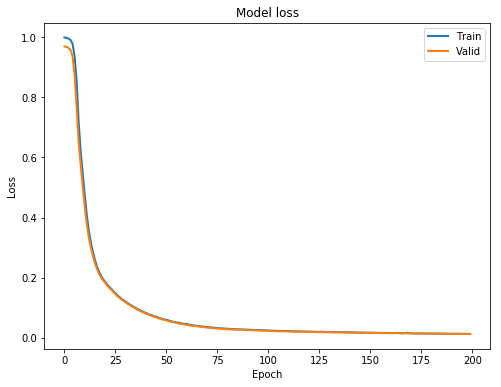

In [36]:
plt.plot(lstm_autoencoder_history['loss'], linewidth=2, label='Train')
plt.plot(lstm_autoencoder_history['val_loss'], linewidth=2, label='Valid')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()

### Sanity check
Doing a sanity check by validating the reconstruction error 
on the train data. Here we will reconstruct the entire train 
data with both 0 and 1 labels.

**Expectation**: the reconstruction error of 0 labeled data should
be smaller than 1.

**Caution**: do not use this result for model evaluation. It may
result into overfitting issues.

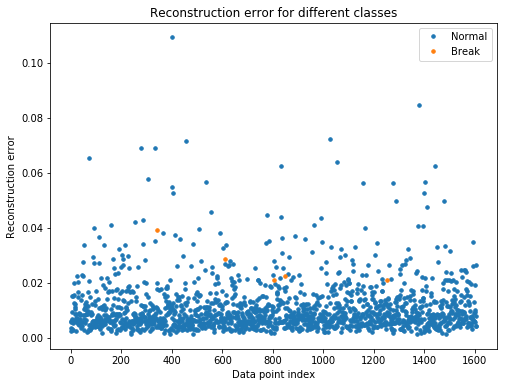

In [37]:
train_x_predictions = lstm_autoencoder.predict(X_train_scaled)
mse = mean(power(flatten(X_train_scaled) - flatten(train_x_predictions), 2), axis=1)

error_df = DataFrame({'Reconstruction_error': mse,
                       'True_class': y_train.tolist()})

groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label = 'Break' if name == 1 else 'Normal')
ax.legend()
plt.title('Reconstruction error for different classes')
plt.ylabel('Reconstruction error')
plt.xlabel('Data point index')
plt.show();

## Predictions using the Autoencoder

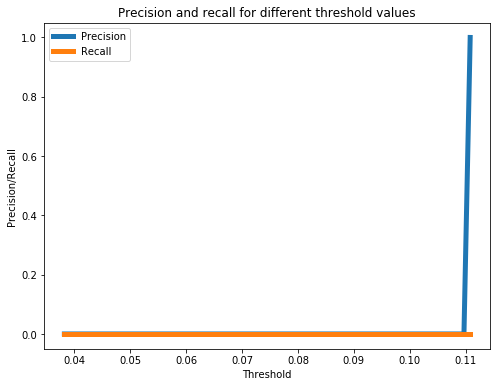

In [38]:
valid_x_predictions = lstm_autoencoder.predict(X_valid_scaled)
mse = mean(power(flatten(X_valid_scaled) - flatten(valid_x_predictions), 2), axis=1)

error_df = DataFrame({'Reconstruction_error': mse,
                        'True_class': y_valid.tolist()})

precision_rt, recall_rt, threshold_rt = precision_recall_curve(error_df.True_class, error_df.Reconstruction_error)
plt.plot(threshold_rt, precision_rt[1:], label='Precision', linewidth=5)
plt.plot(threshold_rt, recall_rt[1:], label='Recall', linewidth=5)
plt.title('Precision and recall for different threshold values')
plt.xlabel('Threshold')
plt.ylabel('Precision/Recall')
plt.legend()
plt.show()

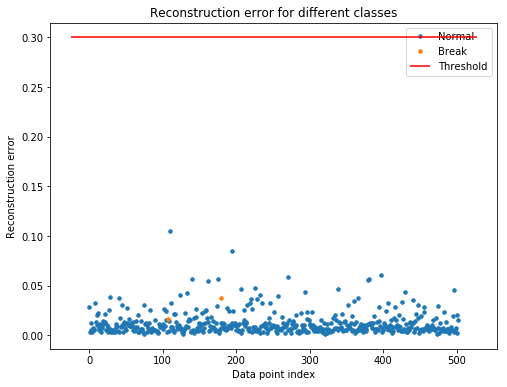

In [39]:
test_x_predictions = lstm_autoencoder.predict(X_test_scaled)
mse = mean(power(flatten(X_test_scaled) - flatten(test_x_predictions), 2), axis=1)

error_df = DataFrame({'Reconstruction_error': mse,
                      'True_class': y_test.tolist()})

threshold_fixed = 0.3
groups = error_df.groupby('True_class')
fig, ax = plt.subplots()

for name, group in groups:
    ax.plot(group.index, group.Reconstruction_error, marker='o', ms=3.5, linestyle='',
            label= "Break" if name == 1 else "Normal")
ax.hlines(threshold_fixed, ax.get_xlim()[0], ax.get_xlim()[1], colors="r", zorder=100, label='Threshold')
ax.legend()
plt.title("Reconstruction error for different classes")
plt.ylabel("Reconstruction error")
plt.xlabel("Data point index")
plt.show();

In [0]:
pred_y = [1 if e > threshold_fixed else 0 for e in error_df.Reconstruction_error.values]

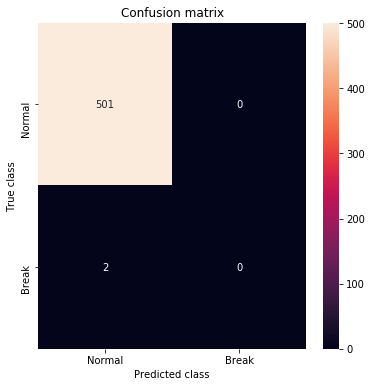

In [41]:
conf_matrix = confusion_matrix(error_df.True_class, pred_y)

plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d");
plt.title("Confusion matrix")
plt.ylabel('True class')
plt.xlabel('Predicted class')
plt.show()

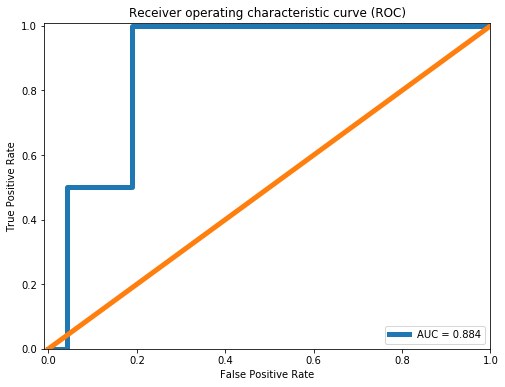

In [42]:
false_pos_rate, true_pos_rate, thresholds = roc_curve(error_df.True_class, error_df.Reconstruction_error)
roc_auc = auc(false_pos_rate, true_pos_rate,)

plt.plot(false_pos_rate, true_pos_rate, linewidth=5, label='AUC = %0.3f'% roc_auc)
plt.plot([0,1],[0,1], linewidth=5)

plt.xlim([-0.01, 1])
plt.ylim([0, 1.01])
plt.legend(loc='lower right')
plt.title('Receiver operating characteristic curve (ROC)')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()